In [1]:
import numpy as np
import cv2
import glob
import os
import pickle
import time

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.svm import *
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score

from scipy.ndimage.measurements import label

%matplotlib inline

In [2]:
data_path = './data/'
const = {
    'vehicles_data' : os.path.join(data_path, 'vehicles/'),
    'non_vehicles_data' : os.path.join(data_path, 'non-vehicles/'),
    'test_images' : './test_images',
    'models' : './models/',
    'project_video' : './project_video.mp4',
    'test_video' : './test_video.mp4'
}

### Data Load and Exploration

In [3]:
def load_images(path):
    imgs_paths = []
    imgs = []
    
    for d in os.listdir(path):
        dir_path = os.path.join(path, d)    
        imgs_paths.extend(glob.glob(os.path.join(dir_path, '*.png')))
    
    
    for path in imgs_paths:
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        imgs.append(img)
    
    return np.asarray(imgs)
    
vehicle_imgs = load_images(const['vehicles_data'])   
non_vehicle_imgs = load_images(const['non_vehicles_data'])   

dataset: vechicles
number of data points: 8792
shape of each point: (64, 64, 3)
data stored in: <class 'numpy.ndarray'>
10 randomly seleted samples:


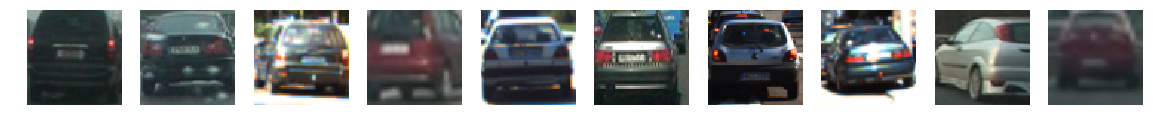

dataset: non-vechicles
number of data points: 8968
shape of each point: (64, 64, 3)
data stored in: <class 'numpy.ndarray'>
10 randomly seleted samples:


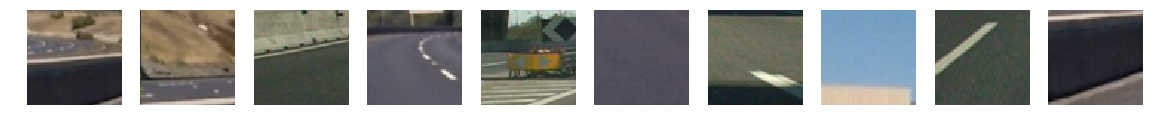

In [4]:
def exploratory_analysis(data, dataset_name=None, seed=13, sample_size=10):
    np.random.seed(seed)
    print('dataset:', dataset_name)
    print('number of data points:', data.shape[0])
    print('shape of each point:', data.shape[1:])
    print('data stored in:', type(data))
    print('{} randomly seleted samples:'.format(sample_size))
    sample_idx = np.random.randint(0, high=data.shape[0]-1, size=sample_size)
    f, ax = plt.subplots(1, sample_size, figsize=(20, 10*sample_size))
    for i, idx in enumerate(sample_idx):
        img = data[idx]
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()
    
exploratory_analysis(vehicle_imgs, dataset_name='vechicles')
exploratory_analysis(non_vehicle_imgs, dataset_name='non-vechicles')

### Feature Extraction

In [5]:
# Helper method to extract hog features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True, transform_sqrt=False):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=transform_sqrt, visualise=vis, 
                                  feature_vector=feature_vec)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=transform_sqrt, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Helper method to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

# Helper method to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

# Helper method to extract features an image
def extract_features(imgs, params): 
    color_space=params['color_space']
    spatial_size=params['spatial_size']
    hist_bins=params['hist_bins'] 
    orient=params['orient']
    pix_per_cell=params['pix_per_cell']
    cell_per_block=params['cell_per_block']
    hog_channel=params['hog_channel']
    spatial_feat=params['spatial_feat']
    hist_feat=params['hist_feat']
    hog_feat=params['hog_feat']
    
    
    features = []
    for image in imgs:
        file_features = []
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      
                
        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        
        if hist_feat:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        
        if hog_feat:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, 
                                                feature_vec=True)
            
            # Append the new feature vector to the features list
            file_features.append(hog_features)

        features.append(np.concatenate(file_features))
    return features

/udacity/jovan/CarND-Vehicle-Detection/.car-nd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


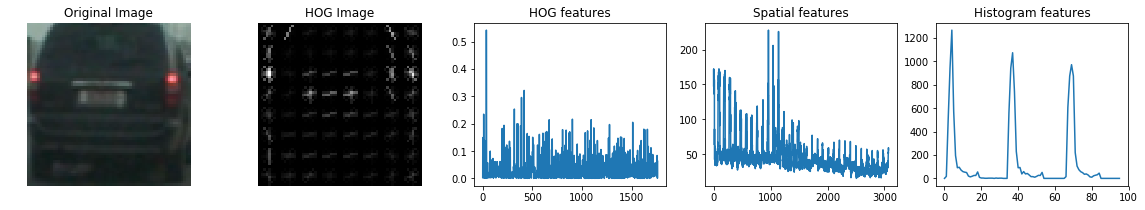

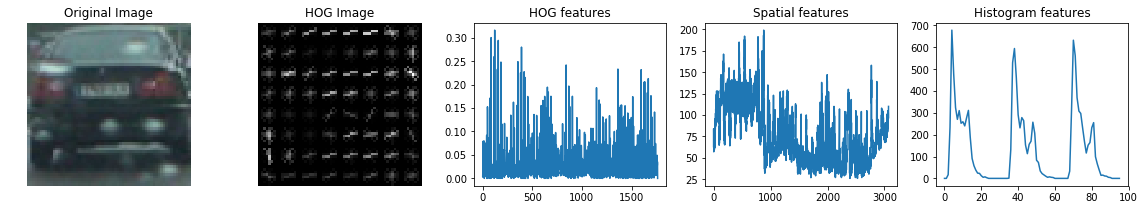

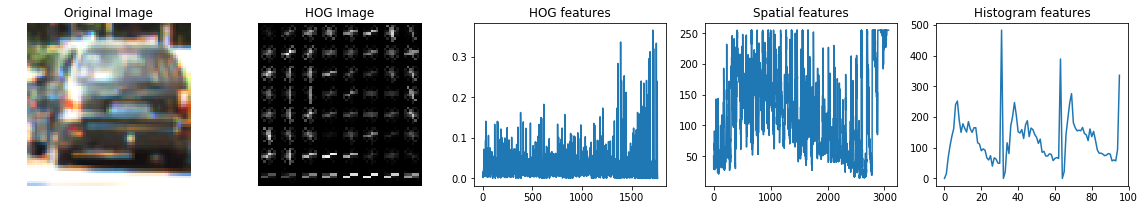

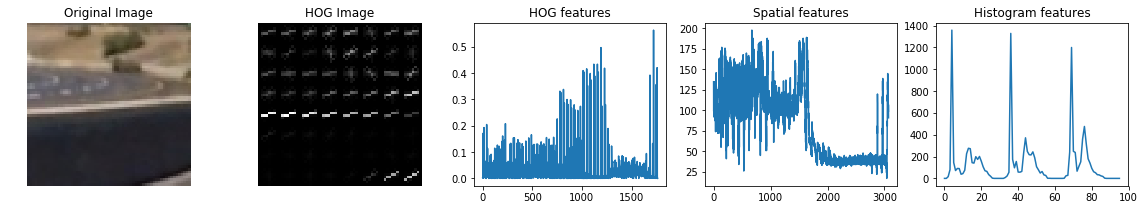

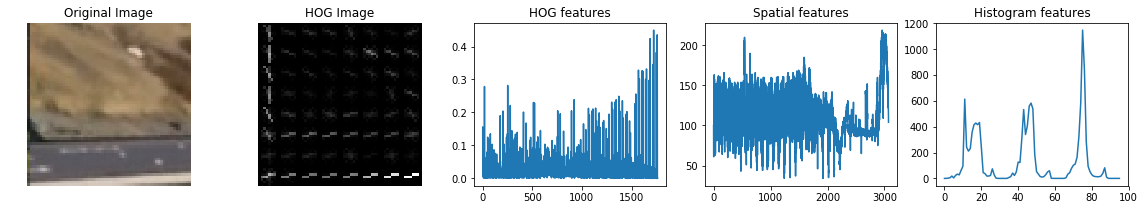

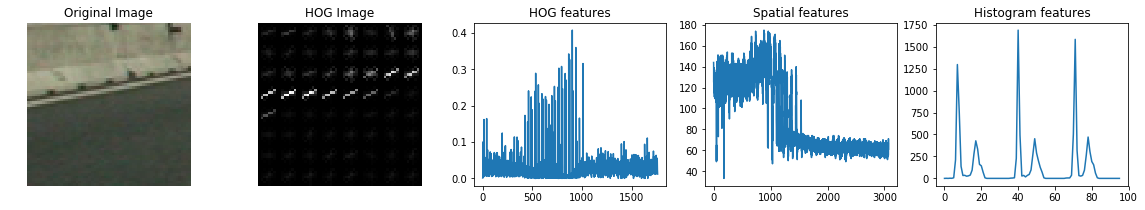

In [6]:
def visualize_features(data, sample_size=3, seed=13):
    np.random.seed(seed)
    random_idxs = np.random.randint(0, high=data.shape[0]-1, size=sample_size)
    for random_idx in random_idxs:
        img = data[random_idx]
        hog_features, hog_img = get_hog_features(img[:,:, 0], 9, 8, 2, vis=True, feature_vec=True)
        spatial_features = bin_spatial(img)
        hist_features = color_hist(img)

        fig, ax = plt.subplots(1, 5, figsize=(20, 3))
        ax[0].imshow(img)
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        ax[1].imshow(hog_img, cmap='gray')
        ax[1].set_title('HOG Image')
        ax[1].axis('off')

        ax[2].plot(hog_features)
        ax[2].set_title('HOG features')

        ax[3].plot(spatial_features)
        ax[3].set_title('Spatial features')

        ax[4].plot(hist_features)
        ax[4].set_title('Histogram features')
        plt.show()
    
visualize_features(vehicle_imgs)
visualize_features(non_vehicle_imgs)

In [7]:
# A list of HOG hyperparams
feature_extraction_hyperparams = {
    'color_space': 'LUV',       # [RGB, HSV, LUV, HLS, YUV, YCrCb]
    'orient': 9,                # HOG orientations
    'pix_per_cell': 16,         # HOG pixels per cell
    'cell_per_block': 2,        # HOG cells per block
    'hog_channel': 'ALL',       # [0, 1, 2, "ALL"]
    'spatial_size': (16, 16),   # Spatial binning dimensions
    'hist_bins': 16,            # Number of histogram bins
    'spatial_feat': True,       # Spatial features on or off
    'hist_feat': True,          # Histogram features on or off
    'hog_feat': True,           # HOG features on or off
}

In [8]:
def data_prep(seed=13):
    vehicle_features = extract_features(vehicle_imgs, feature_extraction_hyperparams)
    non_vehicle_features = extract_features(non_vehicle_imgs, feature_extraction_hyperparams)

    x = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)                        
    scaler = StandardScaler().fit(x)
    x_scaled = scaler.transform(x)
    y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

    x_train, x_val, y_train, y_val = train_test_split(x_scaled, y, test_size=0.2, random_state=seed)
    
    return x_train, x_val, y_train, y_val

x_train, x_val, y_train, y_val = data_prep()

/udacity/jovan/CarND-Vehicle-Detection/.car-nd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


### Model Training

In [9]:
model_hyperparams = {
    'model_type': 'SVM',        # Type of model selected
    'C': 1.0,                   # SVM penalty parameter
    'kernel': 'linear',         # SVM kernel type
    'gamma': 'auto',            # SVM gamma parameter
    'min_samples_split': 5      # min_samples_split for boosting clf
}

In [10]:
def train_model(feature_extraction_hyperparams,
                x_train, x_val, y_train, y_val,
                model_type, save_model=True):
    
    model_stats = {}
    if model_type == 'LinearSVC':
        clf = LinearSVC() 
    elif model_type == 'RandomForestClassifier':
        clf = RandomForestClassifier()
    elif model_type == 'GaussianNB':
        clf = GaussianNB()
    else:
        assert False, '{} is not a supported model_type'.format(model_type)
        
    
    t0 = time.time()
    clf.fit(x_train, y_train)
    t1 = time.time()
    model_stats['training_time'] = t1-t0
    
    y_pred= clf.predict(x_val)
    acc = accuracy_score(y_val, y_pred)
    
    model_stats['valid_acc'] = acc
    
    print('model:{} took {} seconds to train'.format(model_type, round(model_stats['training_time'], 2)))
    print('validation accuracy = {}'.format(round(model_stats['valid_acc'], 4)))
    
    if save_model:
        ts = int(time.time())
        save_loc = os.path.join(const['models'], str(ts))
        if not os.path.exists(save_loc):
            os.makedirs(save_loc)
        
        model_name = "{}-model-{}.pkl".format(model_type, ts)
        #scaler_name = "scaler-{}.pkl".format(ts)
        feature_extraction_hyperparams_name = "FEH-{}.pkl".format(ts)
        model_stats_name = "stats-{}.pkl".format(ts)
        
        pickle.dump(clf, open(os.path.join(save_loc, model_name), "wb"))
        #pickle.dump(scaler, open(os.path.join(save_loc, scaler_name), "wb"))
        pickle.dump(feature_extraction_hyperparams_name, 
                    open(os.path.join(save_loc, feature_extraction_hyperparams_name), "wb"))
        pickle.dump(model_stats, open(os.path.join(save_loc, model_stats_name), "wb"))
        
        print('Saved training assets at loc: {}'.format(save_loc))

train_model(feature_extraction_hyperparams,
            x_train, x_val, y_train, y_val,
            'LinearSVC', save_model=True)

model:LinearSVC took 2.66 seconds to train
validation accuracy = 0.9921
Saved training assets at loc: ./models/1514341097


In [13]:
def check_model_sanity(clf, stats, x, y):
    y_pred = clf.predict(x)
    acc = accuracy_score(y, y_pred)
    if stats['valid_acc'] == acc:
        print('Model PASSED sanity check')
    else:
        assert False, 'Model FAILED sanity check, model assets may be corrupted!'
        

def load_model_assets(ts, x_val, y_val, print_load_stats = True, check_sanity=True):
    save_loc = os.path.join(const['models'], str(ts))    
    
    model_name = glob.glob(os.path.join(save_loc, '*-model-'+ts+'.pkl'))[0].split('/')[-1]
    #scaler_name = "scaler-{}.pkl".format(ts)
    feature_extraction_hyperparams_name = "FEH-{}.pkl".format(ts)
    model_stats_name = "stats-{}.pkl".format(ts)
    
    model = pickle.load(open(os.path.join(save_loc, model_name), "rb"))
    #scaler = pickle.load(open(os.path.join(save_loc, scaler_name), "rb"))
    FEH = pickle.load(open(os.path.join(save_loc, feature_extraction_hyperparams_name), "rb"))
    stats = pickle.load(open(os.path.join(save_loc, model_stats_name), "rb"))
    
    print('model assets loaded.')
    print('model:', model_name)
    #print('scaler:', scaler_name)
    print('feature_extraction_hyperparams:', feature_extraction_hyperparams_name)
    print('model_stats:', model_stats_name)
    
    if check_sanity:
        check_model_sanity(model, stats, x_val, y_val)
    
    return model, FEH, stats
    
ts = '1514341097'
model, FEH, stats = load_model_assets(ts, x_val, y_val)

model assets loaded.
model: LinearSVC-model-1514341097.pkl
feature_extraction_hyperparams: FEH-1514341097.pkl
model_stats: stats-1514341097.pkl
Model PASSED sanity check
